In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# SHAP explorations of mean encoding features
In hierarchical encoding, more general NAICS categories are worse than specific.  For DGI clusters, it's the opposite.  Why? 

Here, I look at SHAP values for the holdout cases for models with hiearchical encodings from DGI vs standard NAICS.  The question is whether the encoded feature is more "important" for one of the cases, and how the response varies with the value of the feature

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import importlib, os, pickle

In [3]:
import seaborn as sns

In [4]:
from sba_gnn.sba_gnn import sg_plot 
sg_plot.plot_defaults()

In [5]:
import shap
import xgboost as xgb

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Import Data

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [8]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

##### Hierarchical encodings only
Map the DGI based encoded feature into the loans

In [9]:
hier_df = pd.read_parquet(Path(setup.temp_path).joinpath('65_DATA_dgi_mhier.parquet'))

In [10]:
print(list(hier_df.columns))

['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'target', 'mhier_NAICS', 'menc_dgi', 'NAICS']


In [11]:
sba_loans = sba_loans.merge(hier_df[['LoanNr_ChkDgt','menc_dgi']],
                            on='LoanNr_ChkDgt')

In [12]:
sba_loans.shape

(688081, 59)

In [13]:
# Encoding column into dictionary
feature_dict = {'menc': 'menc_NAICS', 'naics':'mhier_NAICS',
              'dgi': 'menc_dgi'}

In [14]:
# Order for plots and tables
feature_order = ['menc', 'naics', 'dgi']
num_models = len(feature_order)

In [15]:
sba_loans[feature_dict.values()].corr()

,menc_NAICS,mhier_NAICS,menc_dgi
menc_NAICS,1.000000,0.962039,0.925959
mhier_NAICS,0.962039,1.000000,0.916195
menc_dgi,0.925959,0.916195,1.000000


##### Models

In [16]:
# Standard target encoding
xgb_model_menc = xgb.Booster()
xgb_model_menc.load_model(Path(setup.temp_path).joinpath('04_MODEL_xgboost.json'))

In [17]:
# Hierarchical target encoding by NAICS
xgb_model_naics = xgb.Booster()
xgb_model_naics.load_model(Path(setup.temp_path).joinpath('10_MODEL_xgboost.json'))

In [18]:
# Hierarchical target encoding by DGI
xgb_model_dgi = xgb.Booster()
xgb_model_dgi.load_model(Path(setup.temp_path).joinpath('65_MODEL_xgboost.json'))

In [19]:
# Models into a dictionary
model_dict = {'menc': xgb_model_menc, 'naics':xgb_model_naics,
              'dgi': xgb_model_dgi}

In [20]:
# Predictor dictionary for compactness
predictor_dict = {k: setup.predictor_features + [feature_dict[k]]
                 for k in feature_dict.keys()}

## SHAP Explainers, Values
For the 3 models, generate explainers then explanations

##### Explainers

In [21]:
explainer_dict = {k: \
                  shap.TreeExplainer(model_dict[k],feature_names=predictor_dict[k]) \
              for k in feature_dict.keys()}

In [22]:
explainer_dict

{'menc': <shap.explainers._tree.TreeExplainer at 0x2b3e78ac0>,
 'naics': <shap.explainers._tree.TreeExplainer at 0x2b3e78c10>,
 'dgi': <shap.explainers._tree.TreeExplainer at 0x2b3e78820>}

##### Holdout values

In [23]:
holdout_df = sba_loans[sba_loans['dset_naics_holdout'] == 1]

In [24]:
shap_holdout_dict = {k: 
                     explainer_dict[k].shap_values(holdout_df[predictor_dict[k]])
                     for k in feature_dict.keys()}

##### Random test values

In [25]:
test_nh_df = sba_loans[sba_loans['dset_naics_holdout'] == 0]

In [26]:
shap_test_dict = {k: 
                     explainer_dict[k].shap_values(test_nh_df[predictor_dict[k]])
                     for k in feature_dict.keys()}

## SHAP Dataframes

##### Wide version

In [27]:
# Wide dataframe for a single model
def get_shap_df(data, shap_values, predictor_features, enc_feature):
    df = pd.DataFrame(shap_values, columns=predictor_features,index = data.index) \
        .rename(columns={enc_feature:'enc_shap'})
    df = pd.concat([data[['LoanNr_ChkDgt', 'target', 'NAICS',
                          enc_feature]].rename(columns={enc_feature:'enc_val'}),
                    df], axis=1)
    return df

In [28]:
# Dataframe for multiple models
def get_wide_df(data, shap_dict,
               predictor_dict = predictor_dict,
               feature_dict = feature_dict,
               model_categories = feature_order):
    df = pd.concat([get_shap_df(data, shap_dict[k], predictor_dict[k], feature_dict[k])
                    for k in feature_dict.keys()],
                   keys=feature_dict.keys()) \
        .reset_index(level=0) \
        .rename(columns={'level_0':'model'}) \
        .reset_index(drop=True)
    
    cat_type = pd.CategoricalDtype(categories=feature_order,ordered=True)
    df['model'] =  df['model'].astype(cat_type)
    
    return df

In [29]:
holdout_wide_df = get_wide_df(holdout_df, shap_holdout_dict)

In [30]:
test_wide_df = get_wide_df(test_nh_df, shap_test_dict)

In [31]:
wide_df = pd.concat([holdout_wide_df, test_wide_df],
                    keys = [1, 0]) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'dset_naics_holdout'}) \
    .reset_index(drop=True)

In [32]:
wide_df.head(3)

,dset_naics_holdout,model,LoanNr_ChkDgt,target,NAICS,enc_val,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,enc_shap
0,1,menc,1000146010,0,445299,0.204655,0.088108,-0.001880,0.017768,-0.149431,0.193137,0.170542,0.029723,0.091684
1,1,menc,1000734007,0,512110,0.204655,0.044254,-0.010897,-0.250198,0.049062,-0.053356,-0.995948,-0.003018,0.078733
2,1,menc,1000745006,0,541810,0.204655,-0.000311,-0.352729,0.042809,0.397000,-0.010701,-0.865773,0.000070,-0.021616


In [33]:
wide_df['model'].value_counts()

model
menc     688081
naics    688081
dgi      688081
Name: count, dtype: int64

In [34]:
wide_df.to_parquet(Path(setup.temp_path).joinpath('82_DATA_shap_wide.parquet'))

##### Long version

In [35]:
shap_cols = setup.predictor_features + ['enc_shap']
id_cols = [c for c in wide_df.columns if c not in shap_cols]

In [36]:
id_cols

['dset_naics_holdout', 'model', 'LoanNr_ChkDgt', 'target', 'NAICS', 'enc_val']

In [37]:
long_df = wide_df.melt(id_vars=id_cols)
long_df['enc_feat'] = np.where(long_df['variable'] == 'enc_shap', 1, 0)

In [38]:
long_df.head(3)

,dset_naics_holdout,model,LoanNr_ChkDgt,target,NAICS,enc_val,variable,value,enc_feat
0,1,menc,1000146010,0,445299,0.204655,NoEmp,0.088108,0
1,1,menc,1000734007,0,512110,0.204655,NoEmp,0.044254,0
2,1,menc,1000745006,0,541810,0.204655,NoEmp,-0.000311,0


In [39]:
long_df.to_parquet(Path(setup.temp_path).joinpath('82_DATA_shap_long.parquet'))

##### Long version, aggregated for encoded vs otherlong_df

In [40]:
long_df = pd.read_parquet(Path(setup.temp_path).joinpath('82_DATA_shap_long.parquet'))

In [41]:
long_enc_agg = long_df \
    .groupby(['LoanNr_ChkDgt', 'dset_naics_holdout', 'model', 'enc_feat']) \
    ['value'] \
    .agg('sum') \
    .reset_index()
long_enc_agg['value_abs'] = np.abs(long_enc_agg['value'])

In [42]:
long_enc_agg.head(3)

,LoanNr_ChkDgt,dset_naics_holdout,model,enc_feat,value,value_abs
0,1000014003,0,menc,0,-0.967923,0.967923
1,1000014003,0,menc,1,0.300321,0.300321
2,1000014003,0,naics,0,-1.000643,1.000643


In [43]:
long_enc_agg.shape

(8256972, 6)

## Bar Plots

##### Importance (abs value)

In [44]:
imp_comp_df = long_enc_agg.groupby(['dset_naics_holdout', 'model', 'enc_feat']) \
    ['value_abs'] \
    .agg('mean') \
    .reset_index()

In [45]:
imp_comp_plot_1 = imp_comp_df[imp_comp_df['enc_feat'] == 1]
imp_comp_plot_1

,dset_naics_holdout,model,enc_feat,value_abs
1,0,menc,1,0.340816
3,0,naics,1,0.340379
5,0,dgi,1,0.315791
7,1,menc,1,0.003326
9,1,naics,1,0.033535
11,1,dgi,1,0.031835


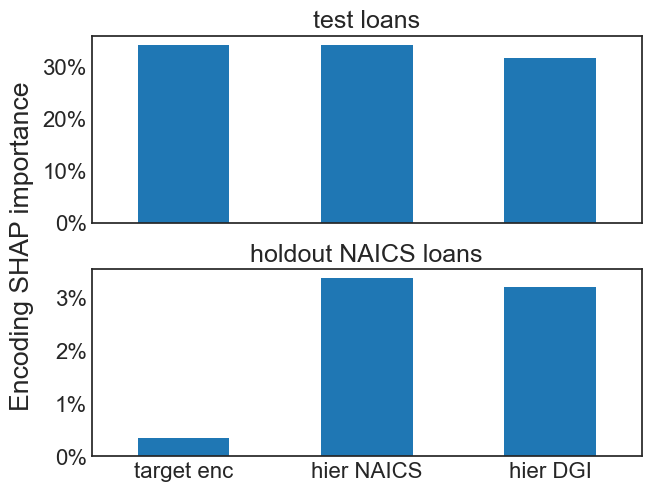

In [46]:
fig, ax = plt.subplots(2, 1, sharex=True,
                      layout='constrained')
imp_comp_plot_1[imp_comp_plot_1['dset_naics_holdout'] == 0] \
    .plot(x='model', y='value_abs', ax=ax[0], kind='bar', legend=None)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax[0].set_title('test loans')
imp_comp_plot_1[imp_comp_plot_1['dset_naics_holdout'] == 1] \
    .plot(x='model', y='value_abs', ax=ax[1], kind='bar', legend=None)
ax[1].set_title('holdout NAICS loans')
ax[1].set_xticklabels(['target enc', 'hier NAICS', 'hier DGI'], rotation=0)
ax[1].set_xlabel(None)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
fig.supylabel('Encoding SHAP importance')
fig.savefig(Path(setup.temp_path).joinpath('82_PLOT_importance_feat.png'))

##### Holdout means

In [47]:
ho_comp_df_1 = long_df[(long_df['enc_feat'] == 1) &
                             (long_df['dset_naics_holdout'] == 1)] \
    .groupby('model') \
    [['value', 'enc_val']] \
    .agg('mean') \
    .reset_index()
ho_comp_df_1

,model,value,enc_val
0,menc,0.018266,0.204655
1,naics,-0.064118,0.196476
2,dgi,-0.176095,0.175107


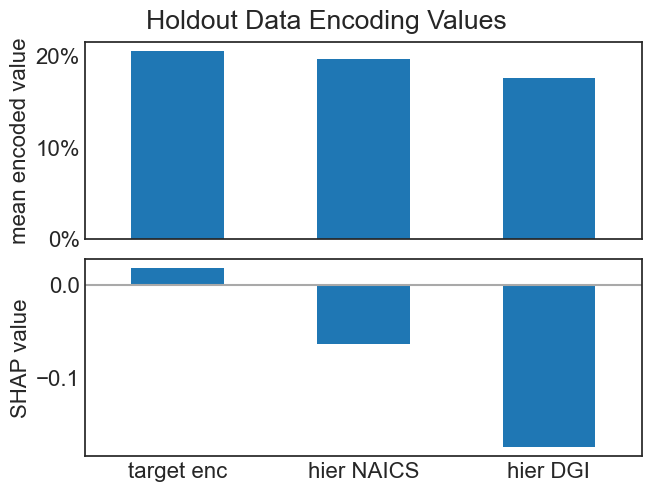

In [64]:
fig, ax = plt.subplots(2, 1, sharex=True,
                      layout='constrained')
ho_comp_df_1.plot(x='model', y='enc_val', ax=ax[0], kind='bar', legend=None)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax[0].set_ylabel('mean encoded value')
ho_comp_df_1.plot(x='model', y='value', ax=ax[1], kind='bar', legend=None)
ax[1].set_ylabel('SHAP value')
ax[1].set_xticklabels(['target enc', 'hier NAICS', 'hier DGI'], rotation=0)
ax[1].set_xlabel(None)
[xmin, xmax] =ax[1].get_xlim()
ax[1].hlines(y=0, xmin=xmin, xmax=xmax, color='darkgray')
fig.suptitle('Holdout Data Encoding Values')
fig.savefig(Path(setup.temp_path).joinpath('82_PLOT_encoding_values_shap_holdout.png'))

## Value Histograms

##### Holdout data, SHAP values for the encoding feature

In [49]:
val_hist_plot_1 = long_df[(long_df['enc_feat'] == 1) & 
                         (long_df['dset_naics_holdout'] == 1)]

In [50]:
groups = val_hist_plot_1.groupby('model')

In [51]:
len(groups)

3

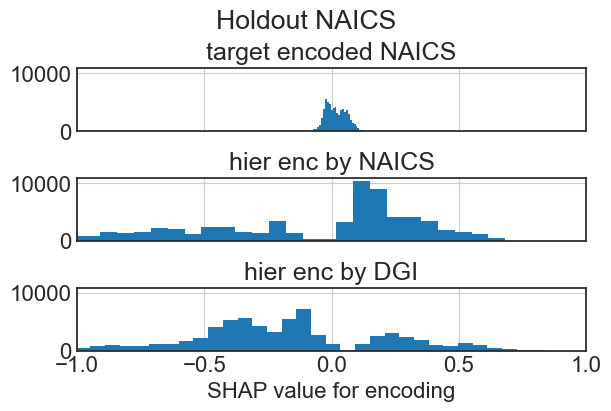

In [52]:
plot_lab = ['target encoded NAICS', 'hier enc by NAICS', 'hier enc by DGI']
fig, ax = plt.subplots(num_models, 1, figsize=(6,4), sharex= True, sharey = True,
                      layout='constrained')
i=0
for n, g in groups:
    g['value'].hist(ax=ax[i], bins=40)
    ax[i].set_title(plot_lab[i])
    i+=1
ax[i-1].set_xlabel('SHAP value for encoding')
ax[i-1].set_xlim(-1, 1, auto=False)
fig.suptitle('Holdout NAICS')
fig.savefig(Path(setup.temp_path).joinpath('82_PLOT_histpgram_holdout_encoding_values.png'))

In [53]:
val_hist_plot_2 = long_df[(long_df['enc_feat'] == 1) & 
                         (long_df['dset_naics_holdout'] == 0)]

In [54]:
groups = val_hist_plot_2.groupby('model')

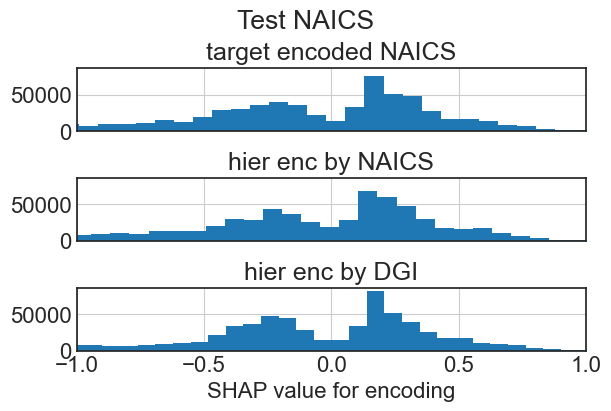

In [55]:
plot_lab = ['target encoded NAICS', 'hier enc by NAICS', 'hier enc by DGI']
fig, ax = plt.subplots(num_models, 1, figsize=(6,4), sharex= True, sharey = True,
                      layout='constrained')
i=0
for n, g in groups:
    g['value'].hist(ax=ax[i], bins=40)
    ax[i].set_title(plot_lab[i])
    i+=1
ax[i-1].set_xlabel('SHAP value for encoding')
ax[i-1].set_xlim(-1, 1, auto=False)
fig.suptitle('Test NAICS')
fig.savefig(Path(setup.temp_path).joinpath('82_PLOT_histpgram_test_encoding_values.png'))

## SHAP dependence

In [56]:
long_df.head(3)

,dset_naics_holdout,model,LoanNr_ChkDgt,target,NAICS,enc_val,variable,value,enc_feat
0,1,menc,1000146010,0,445299,0.204655,NoEmp,0.088108,0
1,1,menc,1000734007,0,512110,0.204655,NoEmp,0.044254,0
2,1,menc,1000745006,0,541810,0.204655,NoEmp,-0.000311,0


In [57]:
dep_plot_1 = long_df[long_df['enc_feat'] == 1] \
    [['model', 'enc_val', 'value']]

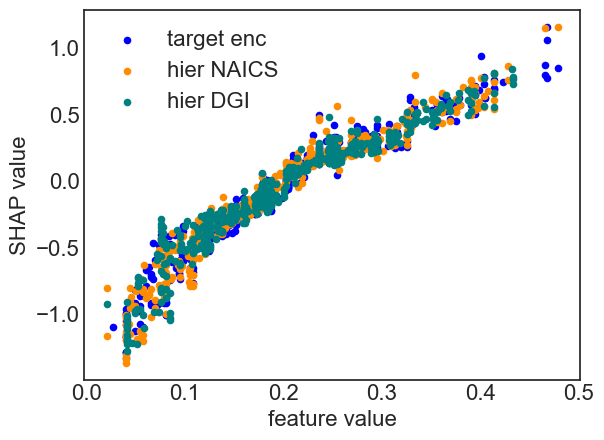

In [58]:
fig, ax = plt.subplots()
groups = dep_plot_1.groupby('model')
colors=['blue', 'darkorange', 'teal']
labels = ['target enc', 'hier NAICS', 'hier DGI']
i = 0
for n, g in groups:
    g.sample(500).plot(x='enc_val', y='value', kind='scatter', ax=ax, color=colors[i],
                       label = labels[i])
    i+=1
ax.set_xlabel('feature value')
ax.set_ylabel('SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('82_PLOT_shap_dependence.png'))

In [59]:
# Smoothed dependence plot
dep_plot_1['bin'] = pd.qcut(dep_plot_1['enc_val'], 20)
dep_plot_2 = dep_plot_1.groupby(['model', 'bin']) \
    [['enc_val', 'value']] \
    .agg('mean') \
    .reset_index()

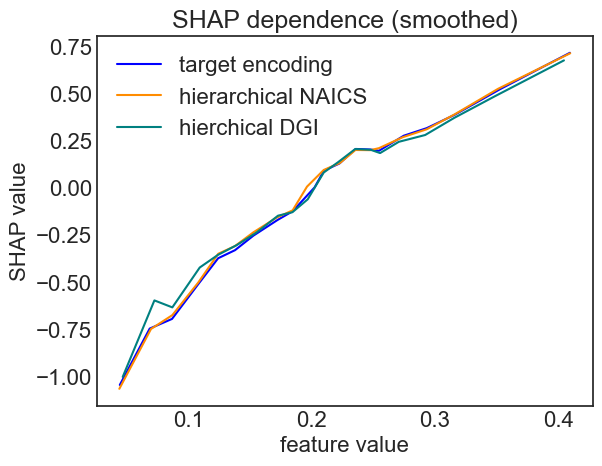

In [67]:
fig, ax = plt.subplots()
groups = dep_plot_2.groupby('model')
colors=['blue', 'darkorange', 'teal']
labels = ['target encoding', 'hierarchical NAICS', 'hierchical DGI']
i = 0
for n, g in groups:
    g.plot(x='enc_val', y='value', kind='line', ax=ax, color=colors[i],
                       label = labels[i])
    i+=1
ax.set_xlabel('feature value')
ax.set_ylabel('SHAP value')
ax.set_title('SHAP dependence (smoothed)')
fig.savefig(Path(setup.temp_path).joinpath('82_PLOT_shap_dependence_smoothed.png'),
           bbox_inches='tight')